In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
# from torch.nn.functional import relu
# from torch.nn.functional import tanh
# from torch.nn.functional import sigmoid
from scipy.fftpack import dct, idct
from scipy.signal import convolve2d

## Reduce the data size by shrinking the image and allow symbolic dynamics to occur (based on doppler-effect).

### Load the data

In [2]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
)
data_len = {'train': len(train_data), 'test': len(test_data)}

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),

    'test': DataLoader(test_data,
                       batch_size=100,
                       shuffle=True,
                       num_workers=1),
}

### Symbolic dynamics through iteration and non-linearity.
Through multiple iterations apply the doppler effect to the DCT of the images and apply convolution.  
Save the results in a dataframe for easy loading.

In [3]:
relu = np.vectorize(lambda x: np.maximum(0, x))
sigmoid = np.vectorize(lambda x: 1 / (1 + np.exp(-x)))
tanh = np.vectorize(np.tanh)

In [4]:
def apply_dynamics(sample, f_act, velocities, v_o, v_m, kernel):
    working_sample = np.copy(sample)

    for i, v_s in enumerate(velocities):
        # apply doppler effect to dct of sample
        s_dct = dct(dct(working_sample.T, norm='ortho').T, norm='ortho')
        s_dct = ((v_m + v_o) / (v_m + v_s)) * s_dct  # doppler-effect
        s_dct = f_act(s_dct)  # activation function
        working_sample = idct(idct(s_dct.T, norm='ortho').T, norm='ortho')
        working_sample = convolve2d(working_sample, kernel, mode='valid')

    return working_sample

In [5]:
iters = 16
velocities = [-(i + 1) / (iters / 3) for i in range(iters)]  # negative if moving towards observer
f_act = tanh  # relu, tanh, sigmoid
# velocities = range(iters)
# velocities = np.full(iters, 1.5)
v_o = 0  # positive if moving towards source
v_m = 5.022
kernel = np.array([[0.25, 0.25],
                   [0.25, 0.25]])

df_results = pd.DataFrame(columns=['data', 'label', 'train'])
for dset in ["train", "test"]:
    batch_size = 100
    batches = data_len[dset] / batch_size
    print(f"Begin reducing {dset}")
    for b, (images, labels) in enumerate(loaders[dset]):
        if b == batches:
            break
        for i in range(batch_size):
            result = apply_dynamics(images[i].numpy()[0], f_act, velocities, v_o, v_m, kernel)
            result_str = np.array2string(result, separator=',')
            df_results = pd.concat([df_results, pd.DataFrame([[result_str, labels[i].numpy(), dset == "train"]], columns=df_results.columns)], ignore_index=True)

        if (b + 1) % 30 == 0:
            print('Reduced [{}/{}] {} batches for {} iterations'
                  .format(b + 1, batches, dset, iters))

print(df_results.shape)
df_results.to_csv(f'RedData/RedData_{iters}i.csv', index=False)

Begin reducing train
Reduced [30/600.0] train batches for 12 iterations
Reduced [60/600.0] train batches for 12 iterations
Reduced [90/600.0] train batches for 12 iterations
Reduced [120/600.0] train batches for 12 iterations
Reduced [150/600.0] train batches for 12 iterations
Reduced [180/600.0] train batches for 12 iterations
Reduced [210/600.0] train batches for 12 iterations
Reduced [240/600.0] train batches for 12 iterations
Reduced [270/600.0] train batches for 12 iterations
Reduced [300/600.0] train batches for 12 iterations
Reduced [330/600.0] train batches for 12 iterations
Reduced [360/600.0] train batches for 12 iterations
Reduced [390/600.0] train batches for 12 iterations
Reduced [420/600.0] train batches for 12 iterations
Reduced [450/600.0] train batches for 12 iterations
Reduced [480/600.0] train batches for 12 iterations
Reduced [510/600.0] train batches for 12 iterations
Reduced [540/600.0] train batches for 12 iterations
Reduced [570/600.0] train batches for 12 itera

### Visualization
Changing `iters` determines the size of the output.

torch.Size([28, 28]) --> (12, 12)


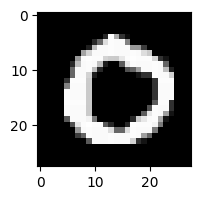

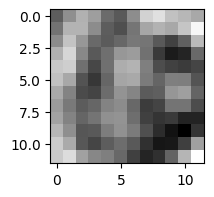

In [6]:
samples, labels = next(iter(loaders['train']))
sample = samples[0][0]

iters = 16
f_act = tanh  # relu, tanh, sigmoid
# vel_s is negative if moving towards observer
velocities = [-(i + 1) / (iters / 3) for i in range(iters)]
# velocities = range(iters)
# velocities = np.full(iters, 1.5)
v_o = 0  # positive if moving towards source
v_m = 5.022
kernel = np.array([[0.25, 0.25],
                   [0.25, 0.25]])

result = apply_dynamics(sample.numpy(), f_act, velocities, v_o, v_m, kernel)
print(f"{sample.shape} --> {result.shape}")

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap='gray')
plt.figure(2, figsize=(2, 2))
plt.imshow(result, cmap='gray')